In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector

db = mysql.connector.connect(host = 'localhost',
                             username = 'root',
                             password = '9934',
                             database = 'ecommerce2')
cur = db.cursor()


### Basic Queries

1. List all unique cities where customers are located.

In [2]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


2. Count the number of orders placed in 2017.

In [3]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

# data # es si sara data aajaiga pichli k tarha
# data[0] # 0 index k call karni si tuple ajaiga
"Total orders placed in 2017 are: ",data[0][0] #0 0 si values hamari pas ajaigi

('Total orders placed in 2017 are: ', 45101)

3. Find the total sales per category.

In [4]:
query = """ select products.product_category as category, round(sum(payments.payment_value),2) as sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by products.product_category """

cur.execute(query)

data = cur.fetchall()

# data 
# make a data frame
df = pd.DataFrame(data, columns=['Category','Sales'])
df.head()

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33


4. Calculate the percentage of orders that were paid in installments.

In [5]:
query = """ select sum(case when payment_installments >= 1 then 1
else 0 end)/count(*)*100 from payments
  """

cur.execute(query)

data = cur.fetchall()

"The percentage of orders tha were pain in installments is: ",data[0][0]

('The percentage of orders tha were pain in installments is: ',
 Decimal('99.9981'))

5. Count the number of customers from each state. 

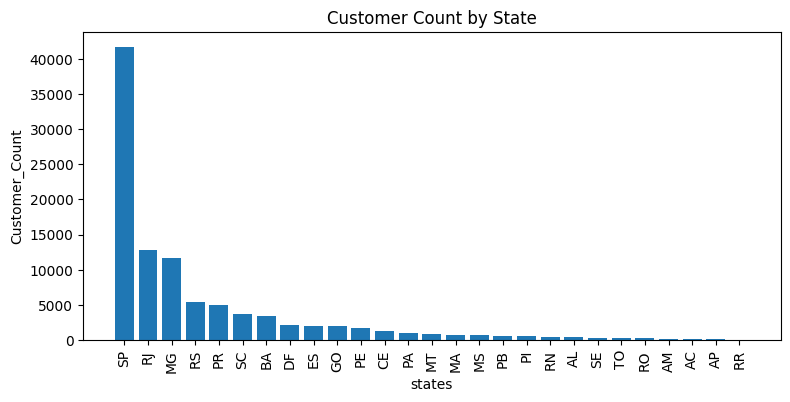

In [6]:
query = """ select customer_state, count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=['state','customer_count'])
df = df.sort_values(by = 'customer_count', ascending=False)

plt.figure(figsize=(9,4))
plt.bar(df['state'],df['customer_count'])
plt.xticks(rotation=90)
plt.xlabel("states")
plt.ylabel("Customer_Count")
plt.title("Customer Count by State")
plt.show()

### Intermediate Queries
1. Calculate the number of orders per month in 2018.

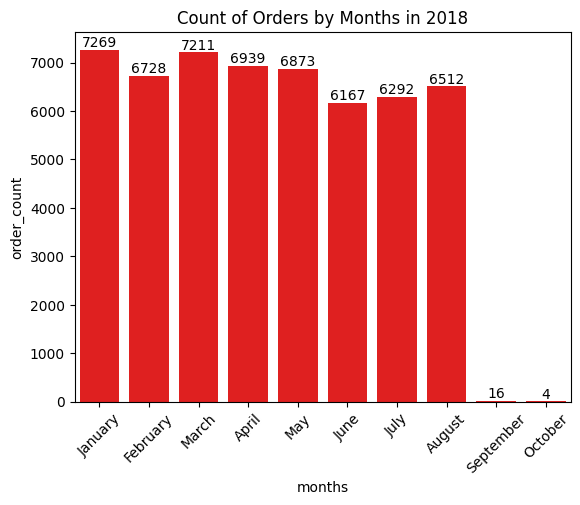

In [7]:
query = """ select monthname(order_purchase_timestamp) months,
count(order_id) order_count
from orders where (order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["months", "order_count"])
o = ['January', 'February','March','April','May','June','July','August','September','October']

ax = sns.barplot(x = df['months'], y = df['order_count'], data =df, order=o, color="red") #hue = df["months"], palette="viridis")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months in 2018")

plt.show()

2. Find the average number of products per order, grouped by customer city.

In [8]:
query = """ with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by	orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) as average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns=["Customer City","Average Products/Order"])
df.head()

,Customer City,Average Products/Order
0,sonora,1.00
1,porteiras,1.00
2,itabi,1.00
3,silvanopolis,1.00
4,salmourao,1.00


3. Calculate the percentage of total revenue contributed by each product category.

In [9]:
query = """ select products.product_category as category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by products.product_category order by sales_percentage desc """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category","Sale_Percentage"])
df.head()

,Category,Sale_Percentage
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93


4. Identify the correlation between product price and the number of times a product has been purchased.

In [10]:
query = """ select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category", "Order_Count", "Price"])

# Co-Relation
arr1 = df["Order_Count"]
arr2 = df["Price"]

a = np.corrcoef([arr1,arr2])
print("The Co-Relation between price and number of times a product has been purchased is: ",a[0][1])

The Co-Relation between price and number of times a product has been purchased is:  -0.10631514167157562


5. Calculate the total revenue generated by each seller, and rank them by revenue.

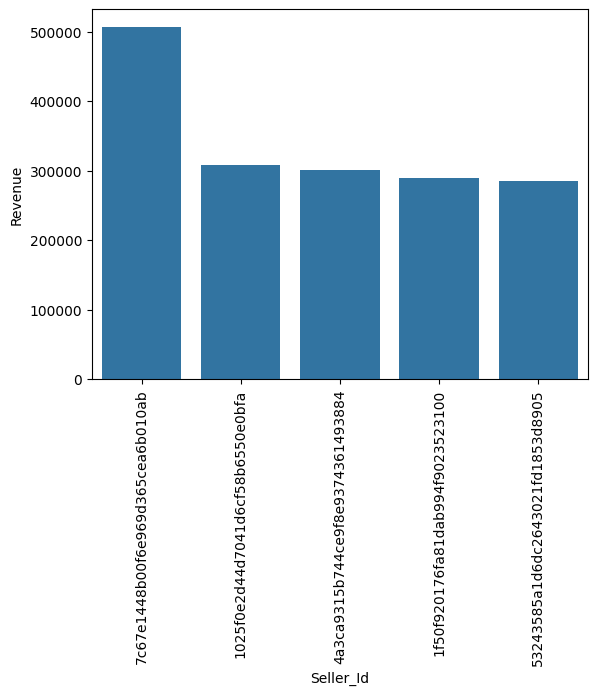

In [11]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value) as revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=['Seller_Id','Revenue','Rank'])
df= df.head()
sns.barplot(data=df, x="Seller_Id", y="Revenue")
plt.xticks(rotation=90)
plt.show()

### Advanced Queries
1. Calculate the moving average of order values for each customer over their order history.

In [12]:
query = """ select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["Customer_Id","Order_Purchase_Timestamp","Payment","Mov_Avg"])
df.head()

,Customer_Id,Order_Purchase_Timestamp,Payment,Mov_Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


2. Calculate the cumulative sales per month for each year. Time: 1:37

In [13]:
query = """select years, months, payment, sum(payment)
over(order by years, months) as cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years,months) as a """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["Years","Months","Payment","Cummulative_Sale"])
df.head()

,Years,Months,Payment,Cummulative_Sale
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


3. Calculate the year-over-year growth rate of total sales.

In [14]:
query = """with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, (payment - lag(payment,1) over(order by years))/
lag(payment,1) over(order by years) *100 from a """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["Years","yoy % growth"])
df

,Years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [16]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order 
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100 *(count(distinct a.customer_id)/ count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id """

cur.execute(query)

data = cur.fetchall()
data

# the output will be "None" because there is no purchase in 6 months

[(None,)]

5. Identify the top 3 customers who spent the most money in each year.

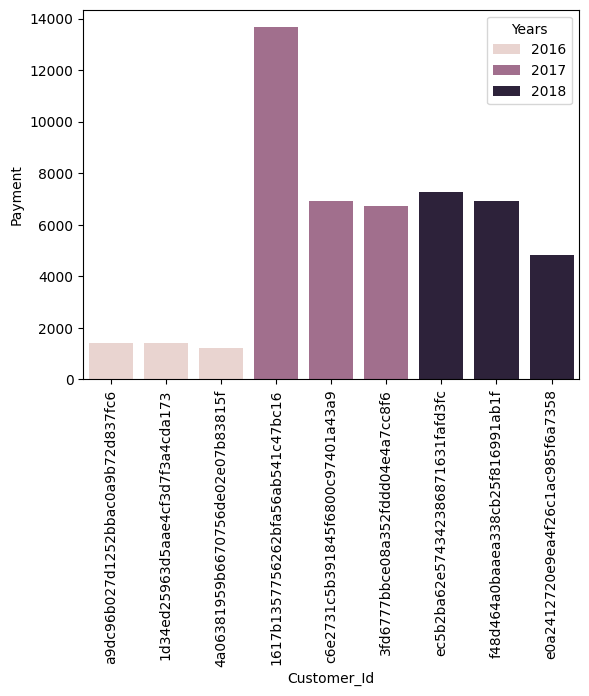

In [27]:
query = """select years, customer_id, payment, d_rank
from 
(select year(orders.order_purchase_timestamp) as years,
orders.customer_id,
sum(payments.payment_value) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value)desc) as d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3; """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["Years","Customer_Id","Payment","D_Rank"])
sns.barplot(x="Customer_Id", y="Payment", data=df, hue="Years")
plt.xticks(rotation=90)
plt.show()